In [41]:
import os
import glob
import librosa
import librosa.display
import wave
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import IPython.display
from IPython.display import display

pd.options.display.max_colwidth = 100

### File paths

In [2]:
b_com_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(b_com_dir, 'data/')
file_name = 'kogara/kogara_gsqueal2.wav'

### Check wav data and melsp data

In [3]:
def load_wave_data(audio_dir, file_name):
    # sr:number>0 target sampling rate
    file_path = os.path.join(audio_dir, file_name)
    x, fs = librosa.load(file_path, sr=44100)
    return x, fs

# change wave data to mel-stft
# ShortTimeFourier
# 音声データを短時間毎に窓で区切って部分をFourier変換する.
# 窓の長さ:n_fft 窓の移動幅:hop_length
def caluculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft, n_mels=128)
    return melsp

def show_wave(x):
    plt.plot(x)
    plt.show()

def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, sr=fs)    
    plt.colorbar()
    plt.show()

wave_size:(445673,)
melsp_size:(128, 3482)
sampling_rate:44100


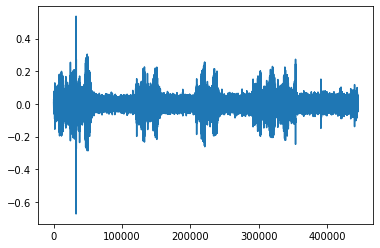

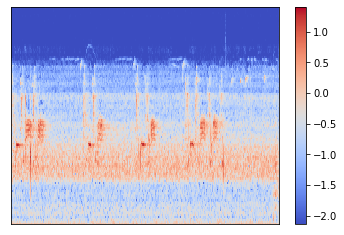

In [4]:
x, fs = load_wave_data(data_dir, file_name)
melsp = caluculate_melsp(x)
print("wave_size:{0}\nmelsp_size:{1}\nsampling_rate:{2}".format(x.shape, melsp.shape, fs))
show_wave(x)
show_melsp(melsp, fs)
display(IPython.display.Audio(x, rate=fs))

### Augumentation

In [5]:
# add white noise
# randn:平均0、分散1 引数はサイズ
def add_white_noise(x, rate=0.002):
    return x + rate*np.random.randn(len(x))

In [6]:
# shift sound in timeframe
# rollでいいのか検討
def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

In [7]:
# stretch sound
def stretch_sound(x, rate=1.1):
    input_length = len(x)
    # Time-stretch an audio series by a fixed rate.
    x = librosa.effects.time_stretch(x, rate)
    if len(x) > input_length:
        return x[:input_length]
    else:
        return np.pad(x, (0, max(1, input_length - len(x))), "constant")

### Training dataset and test dataset

In [51]:
# get training dataset and target dataset
dirs = []
files = []
categories = []
bird_dirs = glob.glob(os.path.join(data_dir,'*'))
for bird_dir in bird_dirs:
    wav_paths = glob.glob(os.path.join(bird_dir,'*'))
    for wav_path in wav_paths:
        wav_file_name = wav_path.split('/')[-1]
        files.append(wav_file_name)
        wav_file_dir = wav_path.replace(wav_file_name, '')
        dirs.append(wav_file_dir)
        categories.append(bird_dir.split('/')[-1])
        
# print(dirs)
# print(files)
# print(categories)

In [52]:
meta_data = pd.DataFrame(list(zip(dirs, files, categories)), columns = ['file_dirs', 'file_names', 'categories'])

In [53]:
def func(row):
    _x, _fs = load_wave_data(row.file_dirs, row.file_names)
    _melsp = caluculate_melsp(_x)
    
    with wave.open(os.path.join(row.file_dirs, row.file_names), 'rb') as wr:
        _ch = wr.getnchannels()
        _width = wr.getsampwidth()
        _fr = wr.getframerate()
        _fn = wr.getnframes()
        
    return pd.Series([_x.shape, _fs, _melsp.shape, _ch, _width, _fr, _fn, _fn/_fr])

meta_data[['wav_shape', 'sample_rates', 'melsp_shape', 'wav_channels', 'wav_sample_size', 'wav_sampling_rate', 'wav_frame_rate', 'wav_time']] = meta_data.apply(func, axis=1)

In [54]:
meta_data

,file_dirs,file_names,categories,wav_shape,sample_rates,melsp_shape,wav_channels,wav_sample_size,wav_sampling_rate,wav_frame_rate,wav_time
0,/home/wataru/code/b-com/b-com/data/sijuukara/,sijuukara_gsqueal6.wav,sijuukara,"(565248,)",44100,"(128, 4417)",2,2,44100,565248,12.817415
1,/home/wataru/code/b-com/b-com/data/sijuukara/,sijuukara_gsqueal5.wav,sijuukara,"(499712,)",44100,"(128, 3905)",2,2,44100,499712,11.331338
2,/home/wataru/code/b-com/b-com/data/sijuukara/,sijuukara_twitter1.wav,sijuukara,"(1196032,)",44100,"(128, 9345)",2,2,44100,1196032,27.120907
3,/home/wataru/code/b-com/b-com/data/sijuukara/,sijuukara_gsqueal8.wav,sijuukara,"(737280,)",44100,"(128, 5761)",2,2,44100,737280,16.718367
4,/home/wataru/code/b-com/b-com/data/sijuukara/,sijuukara_gsqueal2.wav,sijuukara,"(638976,)",44100,"(128, 4993)",2,2,44100,638976,14.489252
5,/home/wataru/code/b-com/b-com/data/sijuukara/,sijuukara_gsqueal4.wav,sijuukara,"(618496,)",44100,"(128, 4833)",2,2,44100,618496,14.024853
6,/home/wataru/code/b-com/b-com/data/sijuukara/,sijuukara_gsqueal7.wav,sijuukara,"(413696,)",44100,"(128, 3233)",2,2,44100,413696,9.380862
7,/home/wataru/code/b-com/b-com/data/sijuukara/,sijuukara_gsqueal3.wav,sijuukara,"(851968,)",44100,"(128, 6657)",2,2,44100,851968,19.319002
8,/home/wataru/code/b-com/b-com/data/sijuukara/,sijuukara_gsqueal9.wav,sijuukara,"(630784,)",44100,"(128, 4929)",2,2,44100,630784,14.303492
9,/home/wataru/code/b-com/b-com/data/sijuukara/,sijuukara_gsqueal1.wav,sijuukara,"(622592,)",44100,"(128, 4865)",2,2,44100,622592,14.117732
